In [25]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import scripts.config as cfg

In [26]:
df = pd.read_csv("../data/scalati.csv.gz")[:cfg.dataset_chunk][
    ["uuid", "date", "n_steps"]]  # I dati sono tanti, non ho una CUDA quindi non posso usarli tutti
df.head()

uuid        date   n_steps
0  1003e58667235e01b49008155604980b3900b00e  2016-08-01 -0.808859
1  1003e58667235e01b49008155604980b3900b00e  2016-08-04 -1.256592
2  1003e58667235e01b49008155604980b3900b00e  2016-08-10 -0.156735
3  1003e58667235e01b49008155604980b3900b00e  2016-08-15  0.123842
4  1003e58667235e01b49008155604980b3900b00e  2016-09-01 -1.382613

In [27]:
df.dropna(inplace=True)  # Magari sui si potrebbe trovare un altro modo

Adesso l'obiettivo è quello di addestrare una rete neurale convoluzionale sulle sequenze di passi degli utenti. Per farle apprendere i vari pattern dirò alla rete di cercare di prevedere l'elemento n+1 della sequenza in funzione dei precedenti n elementi

In [40]:
xtrain = []
ytrain = []
xtest = []
ytest = []
for uuid, group in df.groupby('uuid')[["date","n_steps"]]:
    split = int(
        len(group) * (1 - cfg.test_ratio))  # Fino a "split" le finestre saranno usate per il training, poi per il test
    if split < cfg.window:
        continue

    group=group.values

    for i in range(cfg.window,
                   split):  # Le sequenze sono fatte con una sliding window: Del tipo [1,2,3],[2,3,4],[4,5,6],...
        xtrain.append(group[i - cfg.window:i])
        ytrain.append(group[i,1])  # Deve prevedere l'elemento n+1

    for i in range(split, len(group)):
        xtest.append(group[i - cfg.window:i])
        ytest.append(group[i,1])

# Sistemo gli array in modo che vadano bene alla rete neurale
xtrain = np.array(xtrain).reshape(-1, cfg.window, 2)
ytrain = np.array(ytrain).reshape(-1, 1)
xtest = np.array(xtest).reshape(-1, cfg.window, 2)
ytest = np.array(ytest).reshape(-1, 1)

Ci sono vari modi di definire la rete neurale più adatta, c'è molto da sperimentare e dopo alcuni tentativi questa sembra una configurazione abbastanza ragionevole.

In [41]:
inputs = keras.Input(shape=xtrain[0].shape)
old = inputs
for rate in (1, 2, 4, 8) * 2:
    old = keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                              activation="relu", dilation_rate=rate)(old)
flatten = keras.layers.Flatten()(old)
output = keras.layers.Dense(1)(flatten)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.R2Score()])
model.summary()

#L'ho definita secondo l'API funzionale di Keras, in modo da poter estrarre le attivazioni dei layer intermedi con facilità

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 48, 20)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 48, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,801 (26.57 KB)

 Trainable params: 6,801 (26.57 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo la rete...

In [42]:
from keras.src.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(xtrain, ytrain, epochs=20, verbose=1, validation_split=.2,
                    callbacks=[EarlyStopping(monitor='val_r2_score', patience=5),
                               ModelCheckpoint(filepath='best_model.keras', monitor='val_r2_score',
                                               save_best_only=True)])

Epoch 1/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9739 - r2_score: 0.0118 - val_loss: 0.9671 - val_r2_score: 0.0243
Epoch 2/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9235 - r2_score: 0.0501 - val_loss: 0.9583 - val_r2_score: 0.0332
Epoch 3/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9300 - r2_score: 0.0625 - val_loss: 0.9494 - val_r2_score: 0.0422
Epoch 4/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9218 - r2_score: 0.0709 - val_loss: 0.9605 - val_r2_score: 0.0310
Epoch 5/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9119 - r2_score: 0.0711 - val_loss: 0.9503 - val_r2_score: 0.0413
Epoch 6/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8963 - r2_score: 0.0807 - val_loss: 0.9687 - val_r2_score: 0.0228
Epoch 7/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8934 - r2_score: 0.0790 - val_loss: 0.9580 - val_r2_score: 0.0335
Epoch 8/20
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9039 - r2_score: 0.0795 - 

La curva del training error va bene, quella del validation error ha parecchia varianza ma per ora va bene così

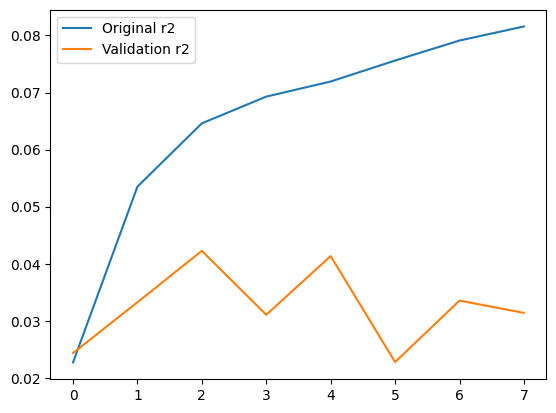

In [43]:
plt.plot(history.history['r2_score'], label='Original r2')
plt.plot(history.history['val_r2_score'], label='Validation r2')
plt.legend()

In [44]:
model.evaluate(xtest, ytest, batch_size=32)

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8901 - r2_score: 0.0767


[0.9144718647003174, 0.06022977828979492]

In [45]:
model.save("../models/modello-passi.keras")

Questa parte serve a visualizzare le abilità di forecasting della rete. È un loop che continua a girare a lungo quindi va fermato a mano.
La parte blu è l'intera sequenza di passi dell'utente, la parte verde è la predizione della rete (fatta iterativamente basandosi su una sorta di sliding window finché non ci sono più dati "reali") sull'andamento dei passi e quella rossa è l'andamento reale.
La qualità delle previsioni sembra ragionevole, anche considerando che lo scopo era solamente apprendere i pattern e non fare il forecasting.

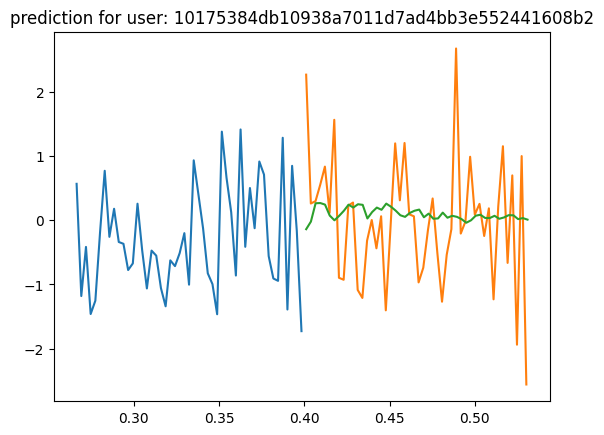

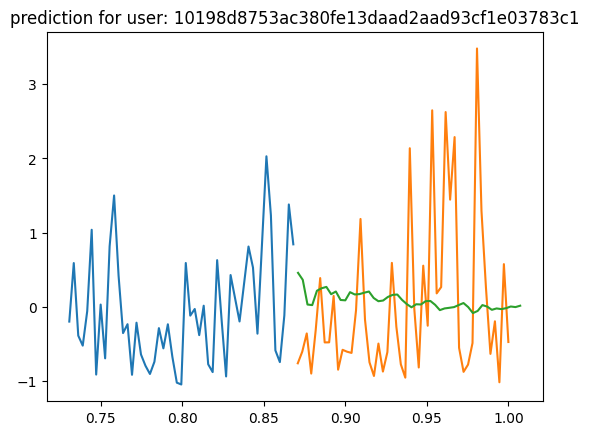

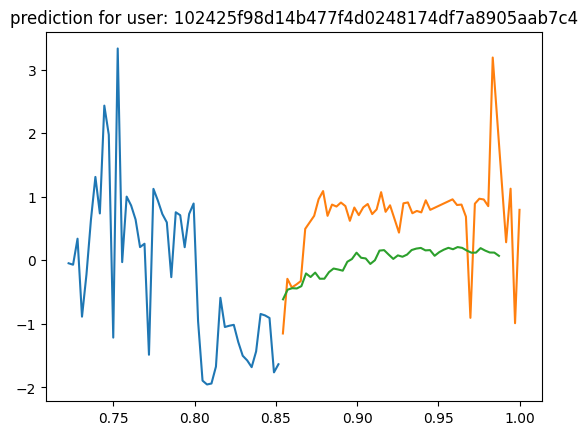

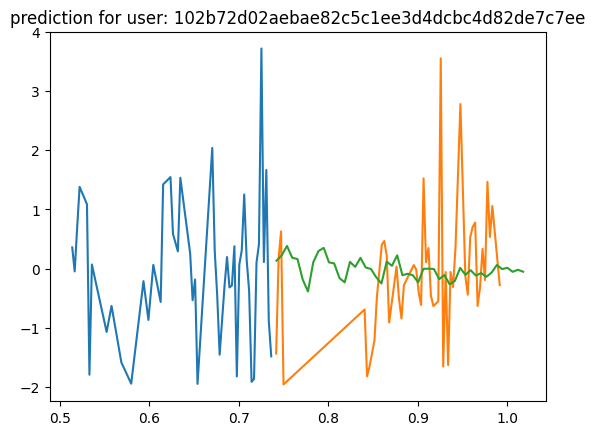

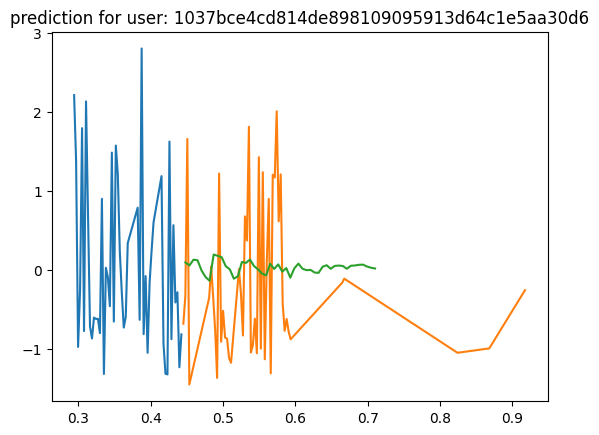

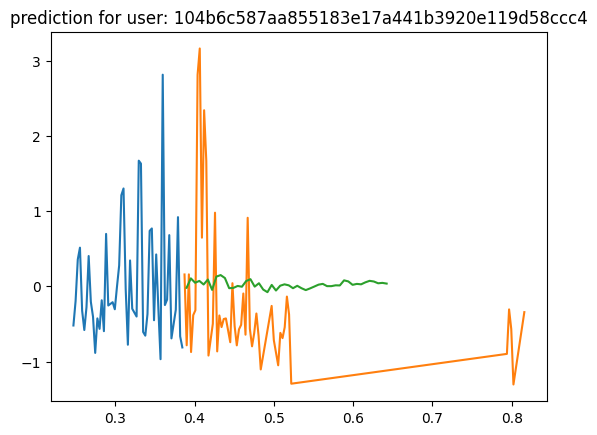

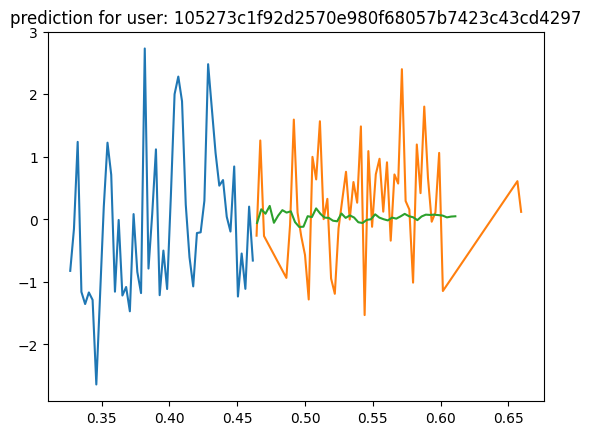

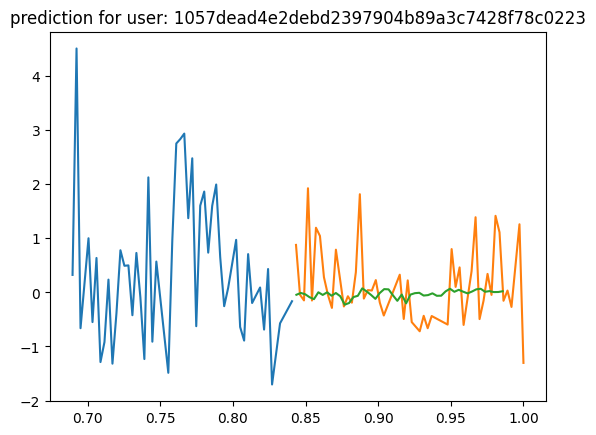

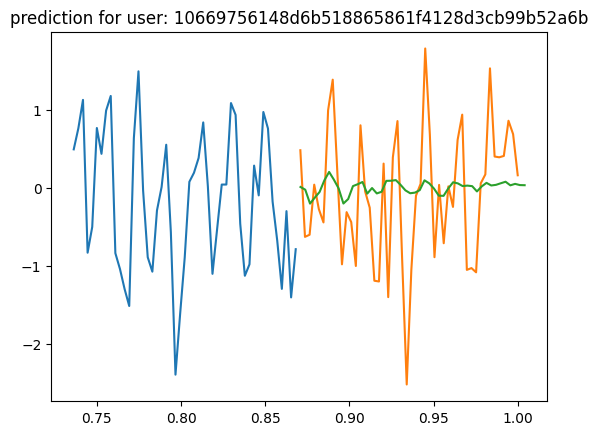

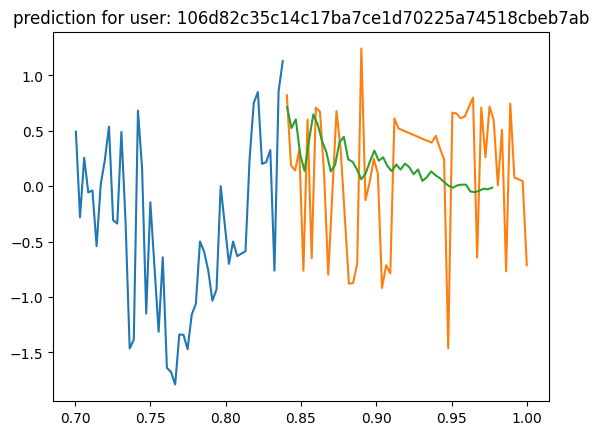

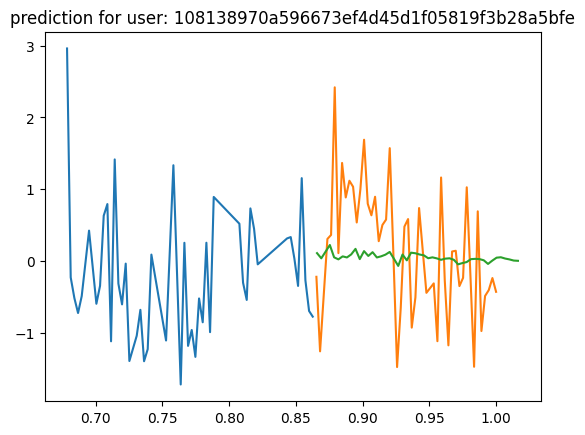

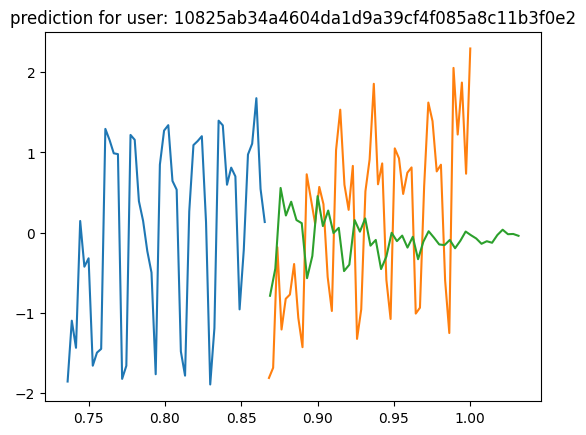

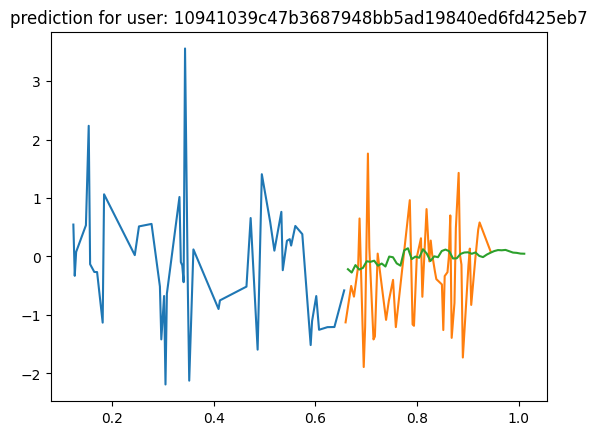

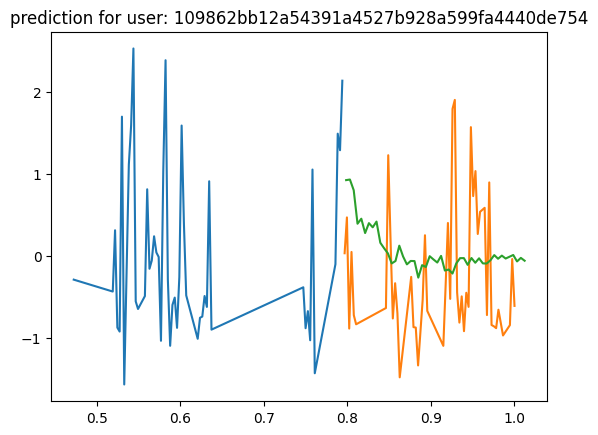

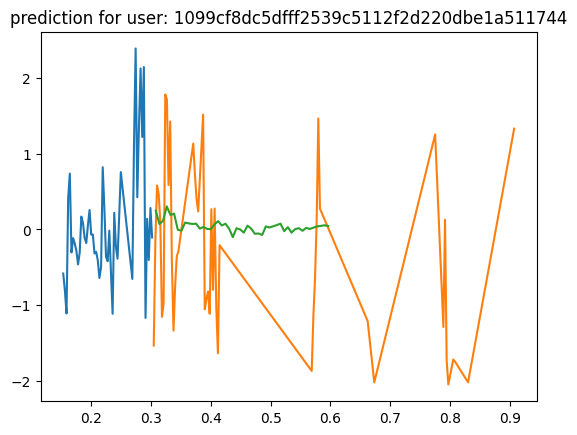

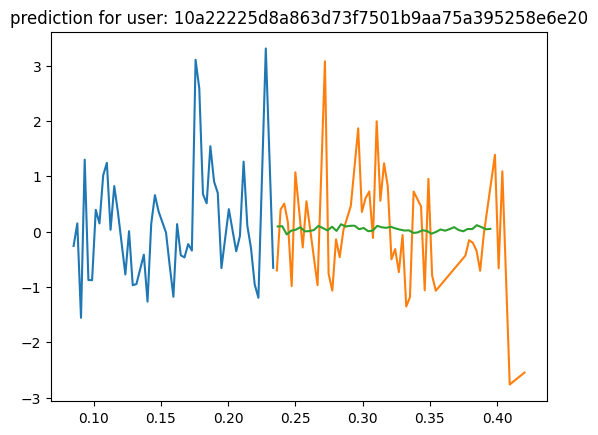

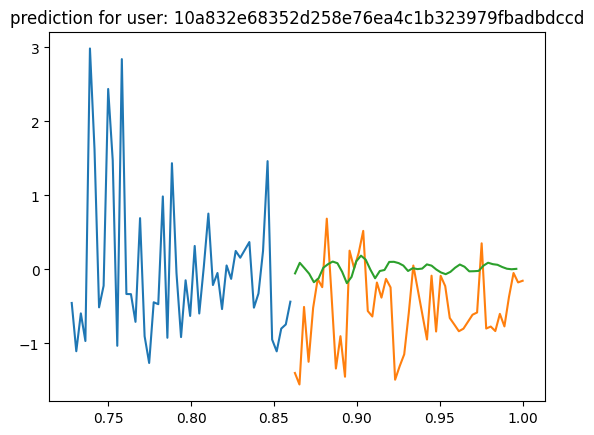

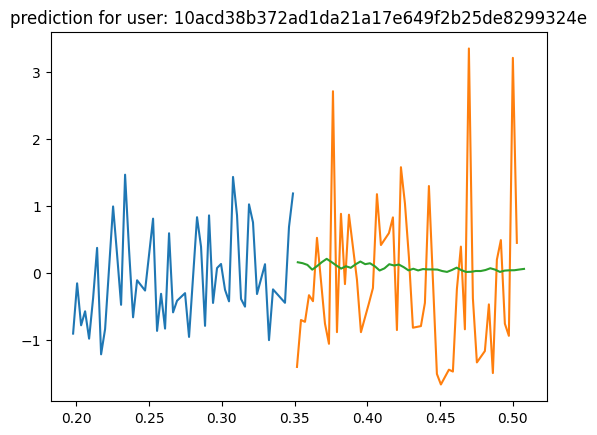

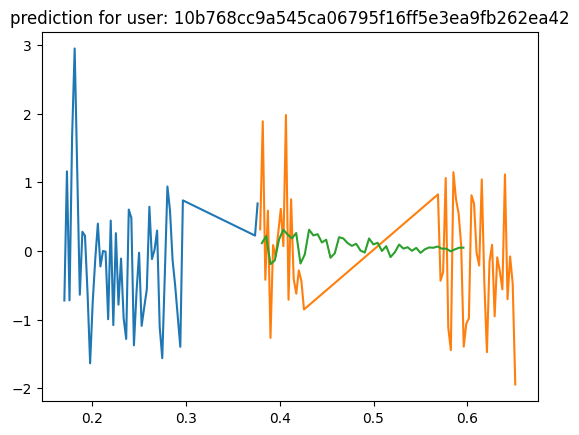

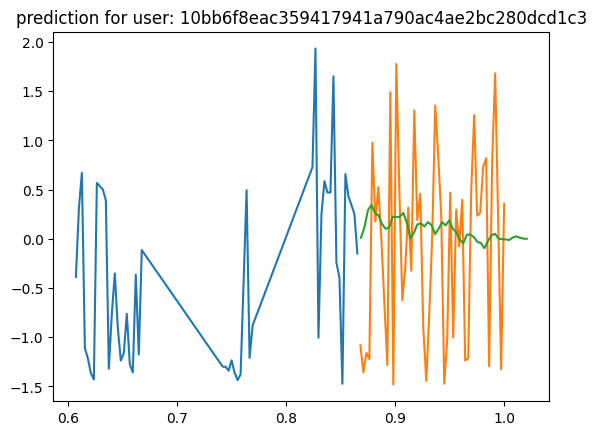

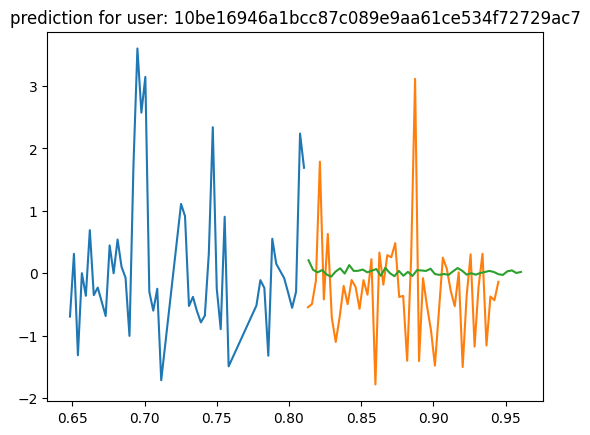

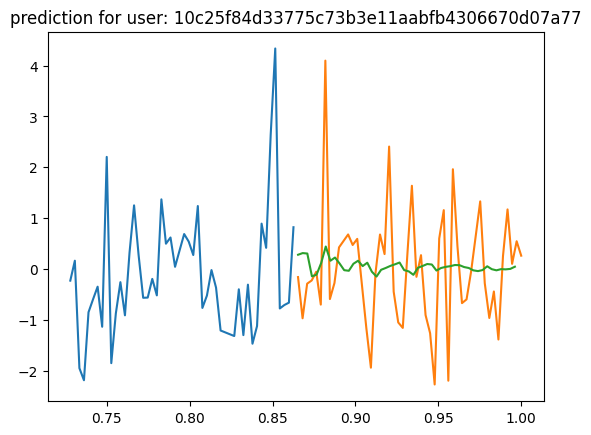

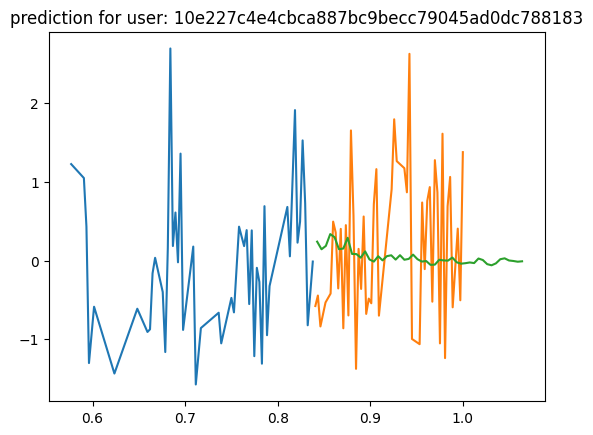

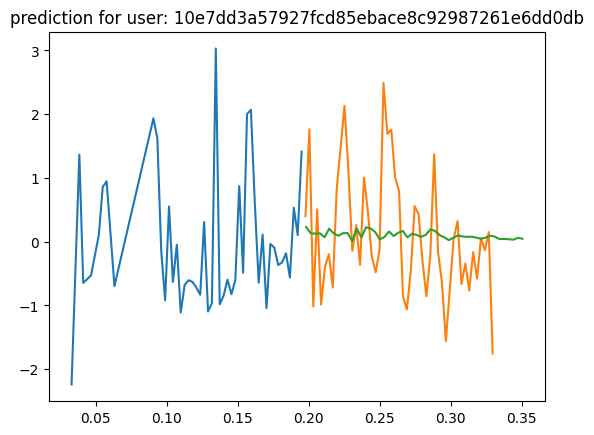

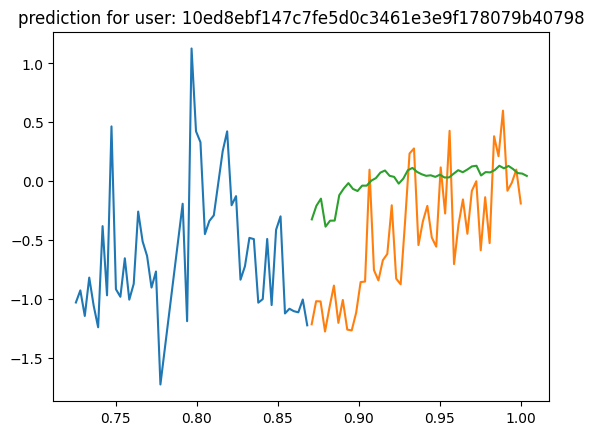

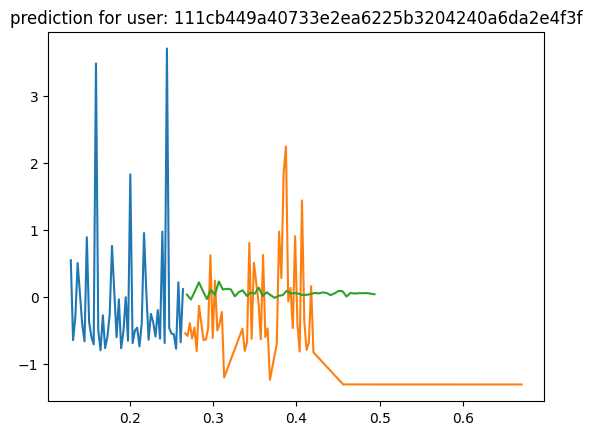

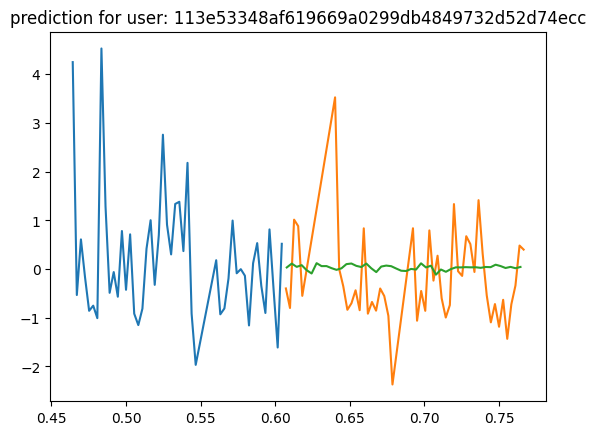

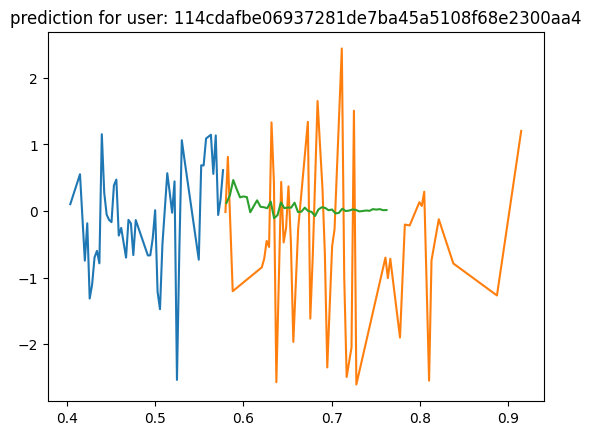

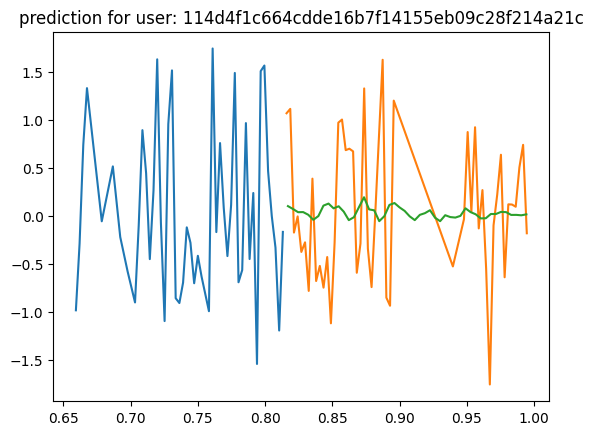

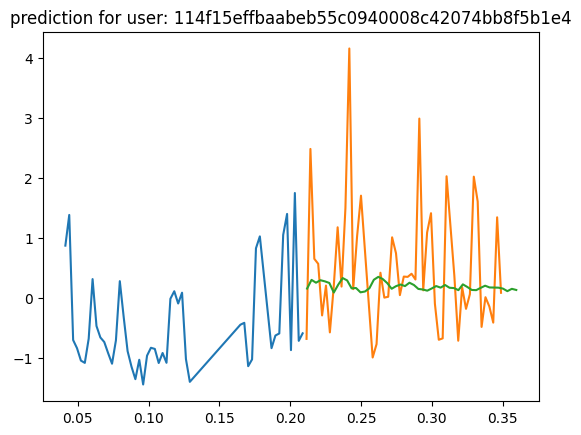

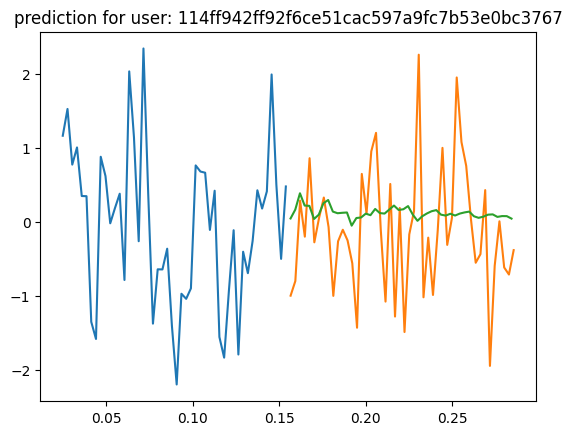

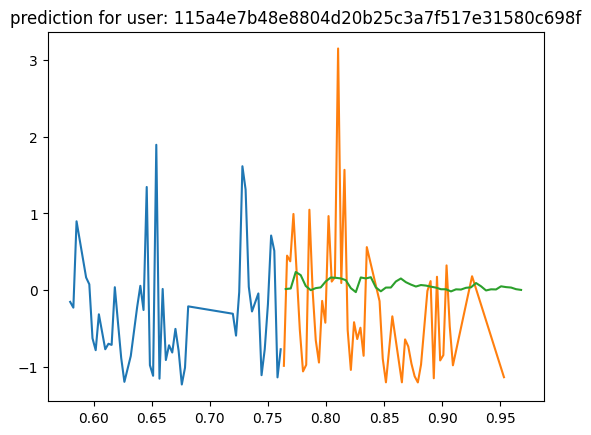

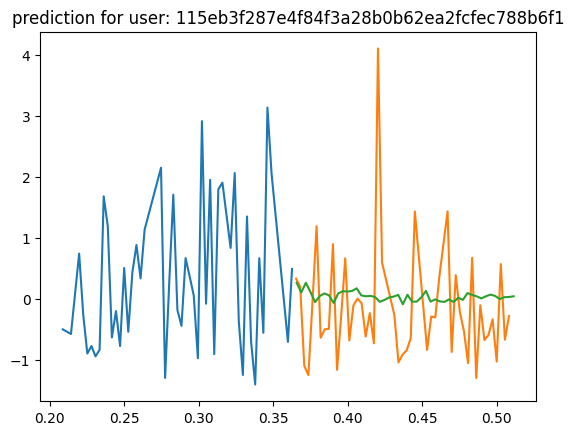

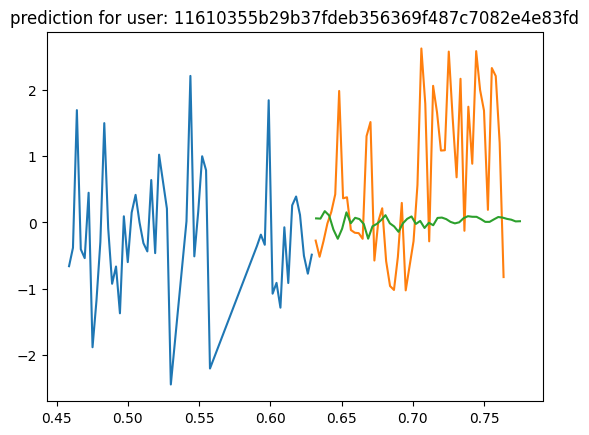

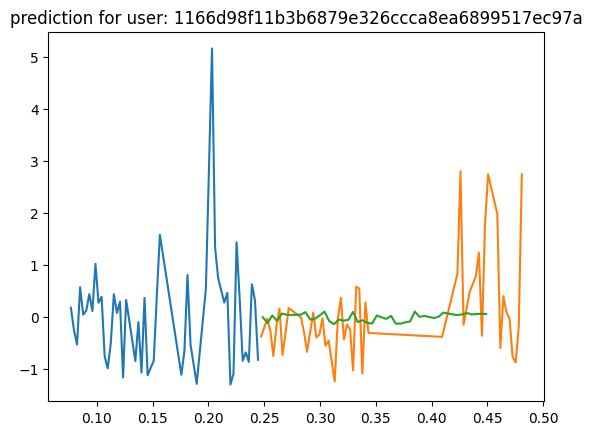

KeyboardInterrupt: 

In [75]:
for uuid, group in df.groupby('uuid')[["date","n_steps"]]:
    if len(group) < 2 * cfg.window:
        continue
    common = group.n_steps[-2 * cfg.window:-cfg.window]
    actual = group.n_steps[-cfg.window:].values
    pred = []
    dati = group[-2*cfg.window:-cfg.window].values
    avg_timestep = (group.date.max()-group.date.min())/len(group)
    timer= avg_timestep + dati[-1,0]
    for i in range(cfg.window):
        new_entry = [[
            timer, model.predict(np.array([dati]), verbose=0)[0][0]
        ]]
        timer+=avg_timestep
        pred.append(new_entry)
        dati = np.concatenate((dati, new_entry))[-cfg.window:]
    pred = np.array(pred)
    plt.title("prediction for user: " + uuid)
    plt.plot(group[-2 * cfg.window:-cfg.window].date,group[-2 * cfg.window:-cfg.window].n_steps, label='Truth')
    plt.plot(group[-cfg.window:].date,group[-cfg.window:].n_steps, label='Actual')
    plt.plot(dati[:,0], dati[:,1], label='Predicted')
    plt.show()
    plt.close()


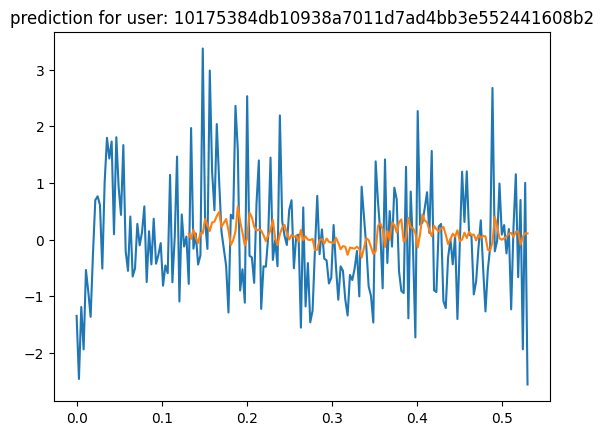

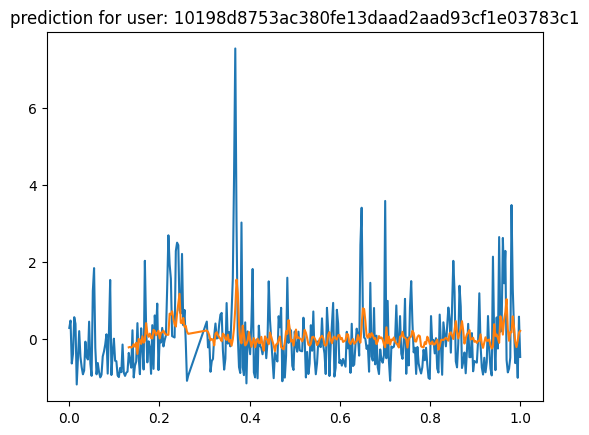

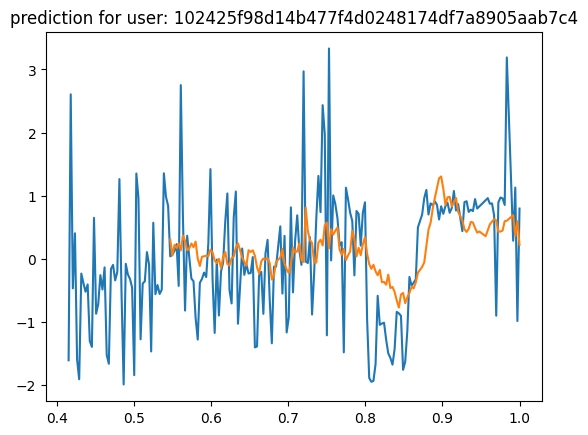

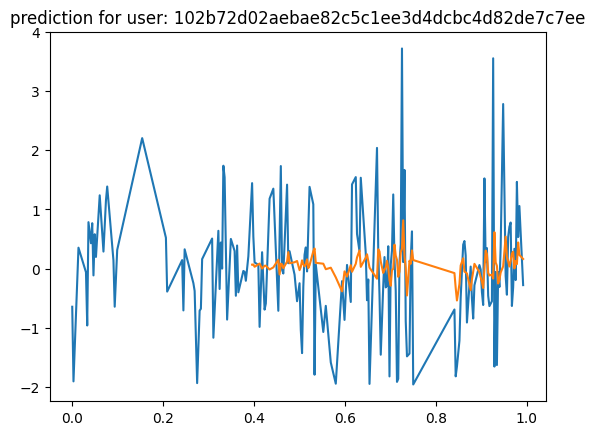

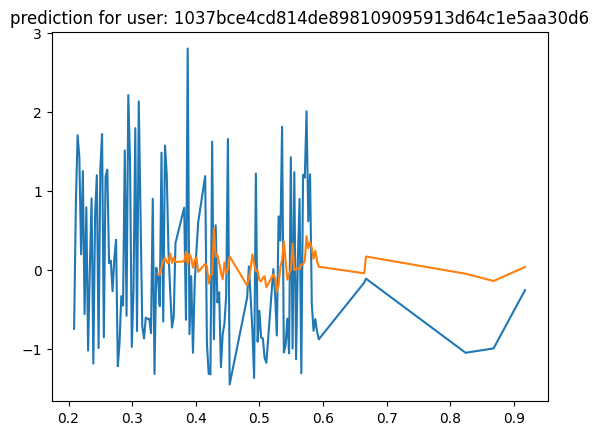

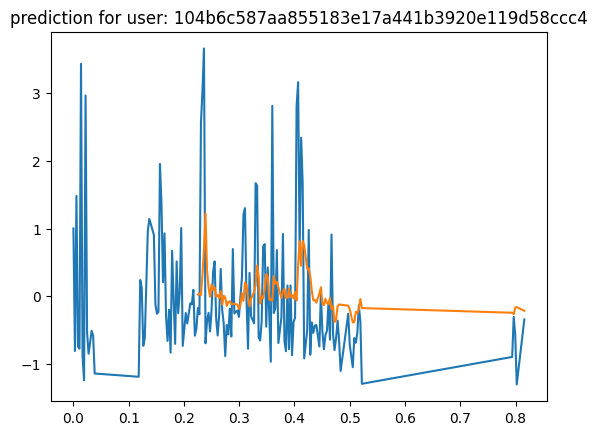

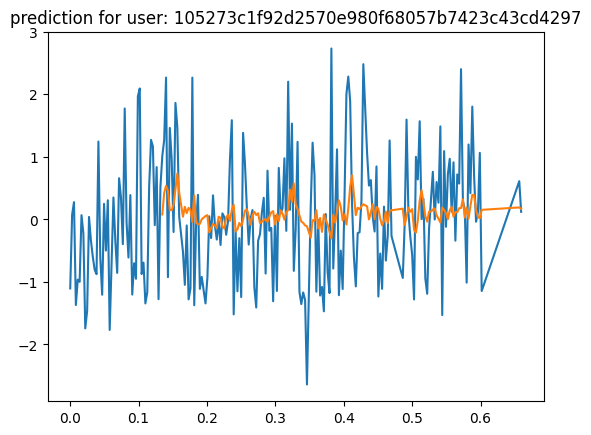

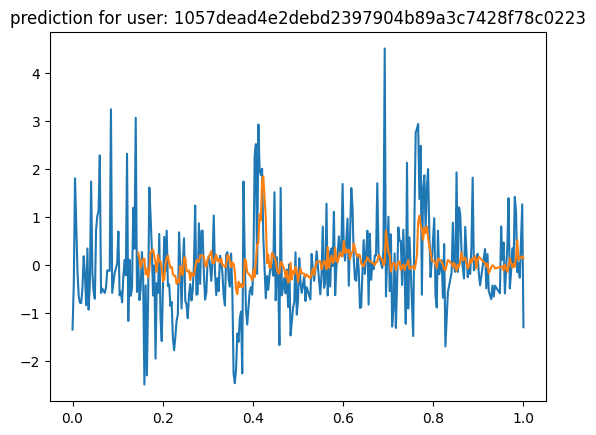

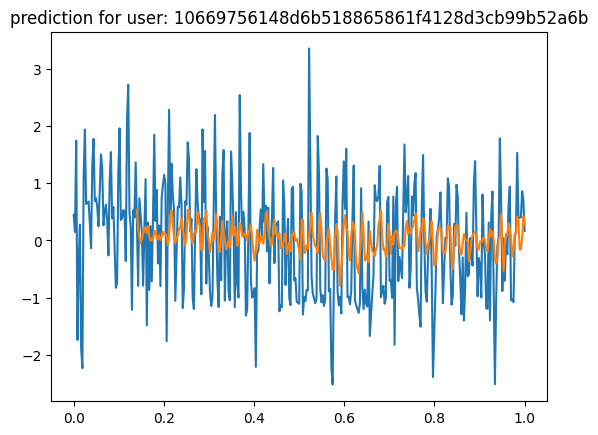

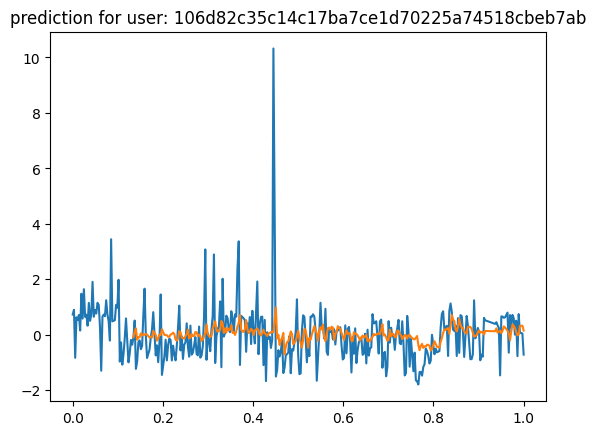

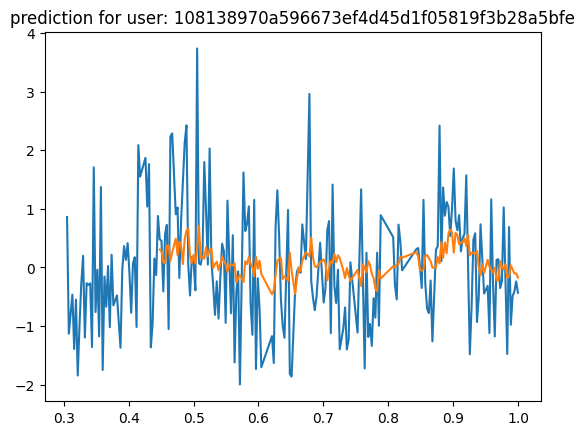

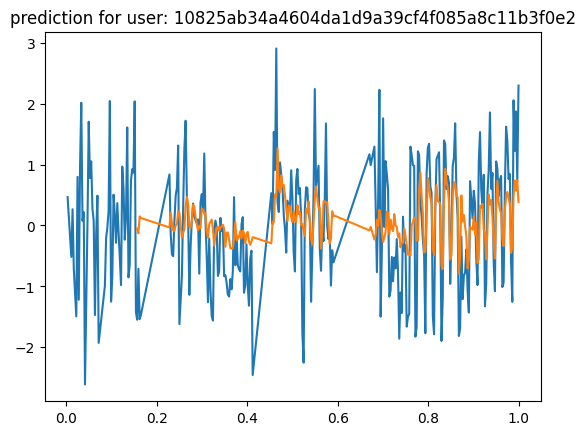

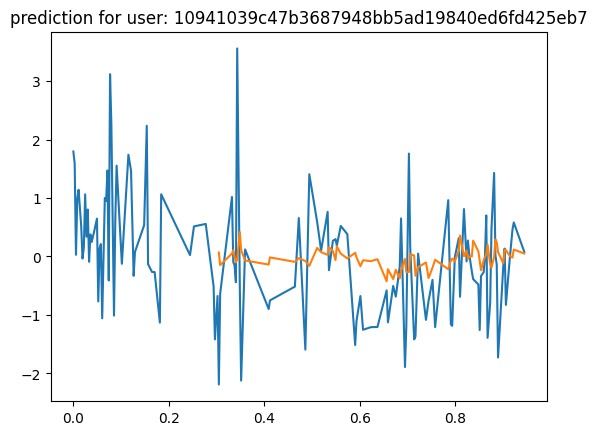

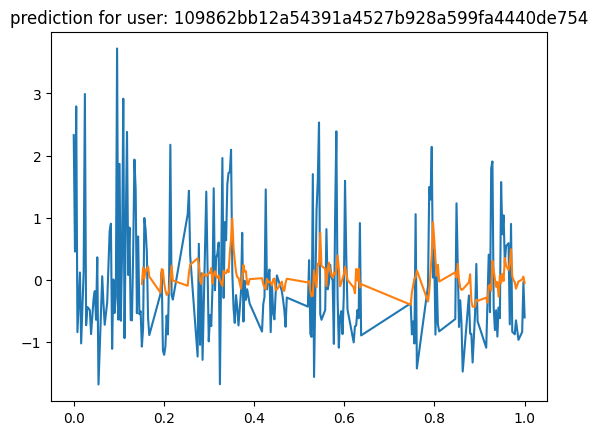

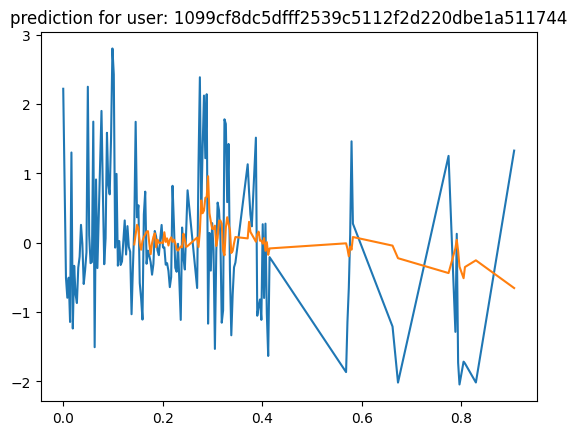

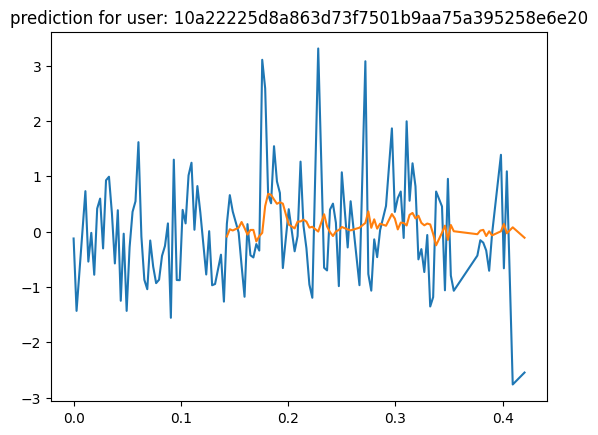

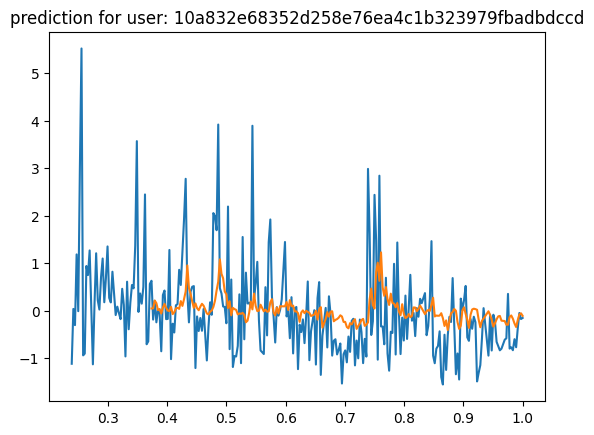

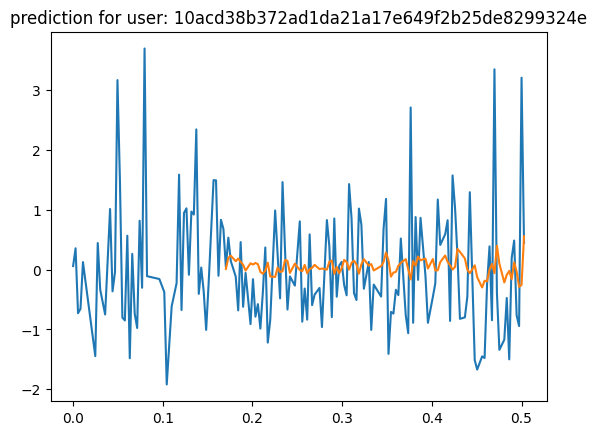

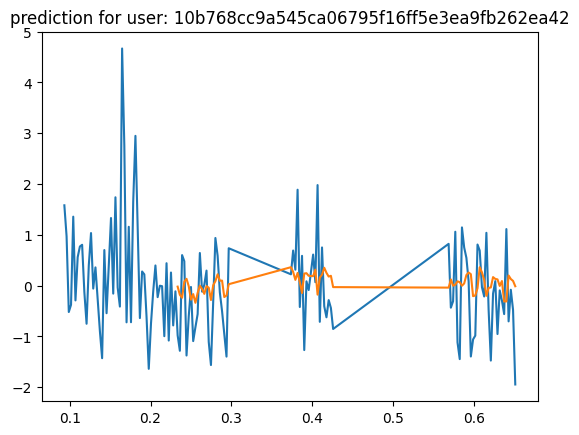

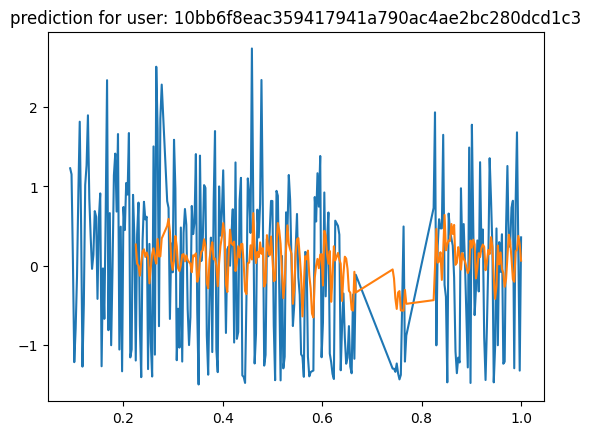

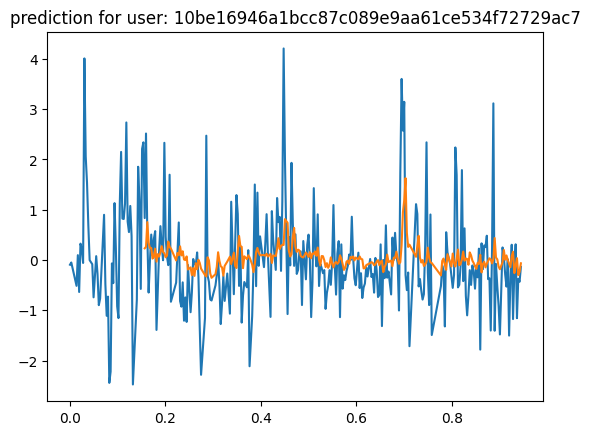

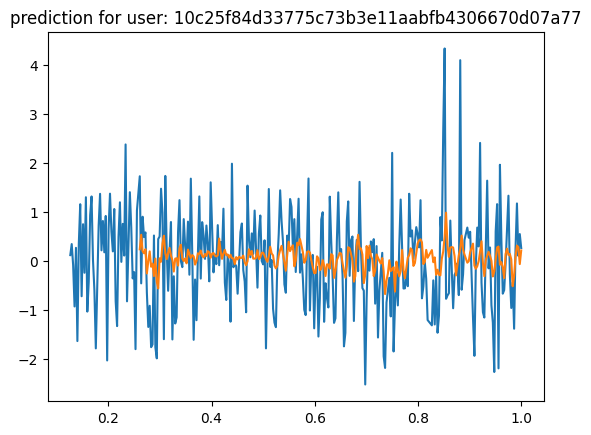

KeyboardInterrupt: 

In [86]:
for uuid, group in df.groupby('uuid')[["date","n_steps"]]:
    if len(group) < 2 * cfg.window:
        continue
    common = group.values
    data = []
    for i in range(cfg.window, len(common)):
        data.append(group[i - cfg.window:i])
    data=np.array(data)
    pred = model.predict_on_batch(data)
    plt.title("prediction for user: " + uuid)
    plt.plot(group.date.values, group.n_steps.values, label='Truth')
    plt.plot(group.date[cfg.window:].values, pred, label='Predicted')
    plt.show()
    plt.close()
